##  Подбор параметров

Подберём параметр $k:$
$$
\lambda(\delta) = A e^{-k\delta}
$$где $\lambda(\delta)$ -- интенсивность исполнения наших заявок при условии, что заявка стоит на расстоянии $\delta$ от мид прайса, $A$ -- нормировочная константа. 

Введём сетку по $\delta: 0 < \delta_0 < \ldots < \delta_{K-1}$ и для каждого $\delta_i$ посчитаем, сколько рыночных заявок пробило стакан больше, чем на $\delta_i$. Обозначим это число через $N_i$. Тогда константу $k$ можно найти из линейной регрессии:
$$
\log N_i = -k \delta_i + C
$$при $C = \log A$

При решении первого ДЗ я уже считал эти статистики, а именно на сколько каждая рыночная заявка пробивает стакан.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
bid_trades_group = pd.read_csv("../md/bid_trades_group.csv")
ask_trades_group = pd.read_csv("../md/ask_trades_group.csv")

bid_trades_group["exchange_dt"] = pd.to_datetime(bid_trades_group["exchange_dt"])
ask_trades_group["exchange_dt"] = pd.to_datetime(ask_trades_group["exchange_dt"])

Под маркет одером я понимаю сделки, произведённые в один и тот же `exchange_ts`. В этом датасете `size` -- суммарный размер маркет ордера, `mean_price` -- средневзвешенная цена, `first_price, last_price` -- первая и последняя цена покупки, `delta` -- их разница, по сути величина пробития стакана.

In [3]:
display(bid_trades_group.head(5))

,exchange_dt,size,mean_price,first_price,last_price,delta,n_trades,nunique_price
0,2022-06-23 00:00:02.623,0.001,19977.500000,19977.5,19977.5,0.0,1.0,0.0
1,2022-06-23 00:00:05.292,0.086,19977.530233,19977.5,19978.0,0.5,7.0,3.0
2,2022-06-23 00:00:09.193,0.150,19978.000000,19978.0,19978.0,0.0,4.0,0.0
3,2022-06-23 00:00:09.198,0.199,19978.000000,19978.0,19978.0,0.0,1.0,0.0
4,2022-06-23 00:00:09.202,0.167,19978.000000,19978.0,19978.0,0.0,3.0,0.0


In [4]:
display(ask_trades_group.head(5))

,exchange_dt,size,mean_price,first_price,last_price,delta,n_trades,nunique_price
0,2022-06-23 00:00:08.890,0.020,19977.9,19977.9,19977.9,0.0,1.0,0.0
1,2022-06-23 00:00:09.193,0.233,19977.9,19977.9,19977.9,0.0,2.0,0.0
2,2022-06-23 00:00:09.233,0.032,19977.9,19977.9,19977.9,0.0,1.0,0.0
3,2022-06-23 00:00:09.244,0.021,19977.9,19977.9,19977.9,0.0,1.0,0.0
4,2022-06-23 00:00:09.253,0.010,19977.9,19977.9,19977.9,0.0,1.0,0.0


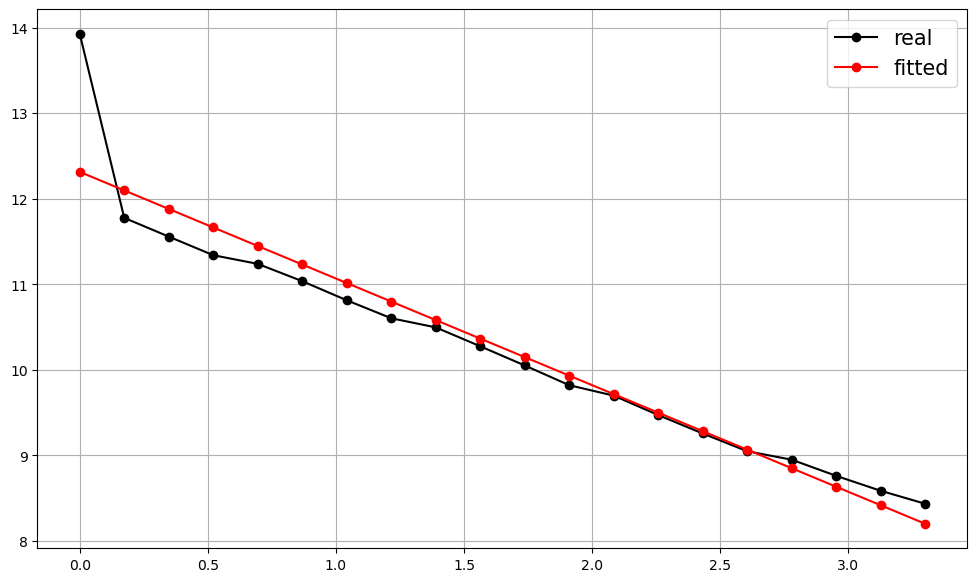

scale:  -1.2461632499213062


In [5]:
delta = ask_trades_group.delta.values
dmax = np.quantile(delta[delta > 0], 0.97)

deltas = np.linspace(0, dmax, 20)

res = np.zeros_like(deltas)

for i, d in enumerate(deltas):
    res[i] = np.sum( delta >= d )

scale, loc = np.polyfit(deltas, np.log(res), deg=1)
    
y = loc + deltas * scale

plt.figure(figsize=(12, 7))
plt.plot(deltas, np.log(res), '-ok', label='real')
plt.plot(deltas, y, '-or', label='fitted')
plt.grid()
plt.legend(fontsize=15)
plt.show()

print("scale: ", scale)

Тоже самое, но с выброшенной первой точкой $\delta = 0$

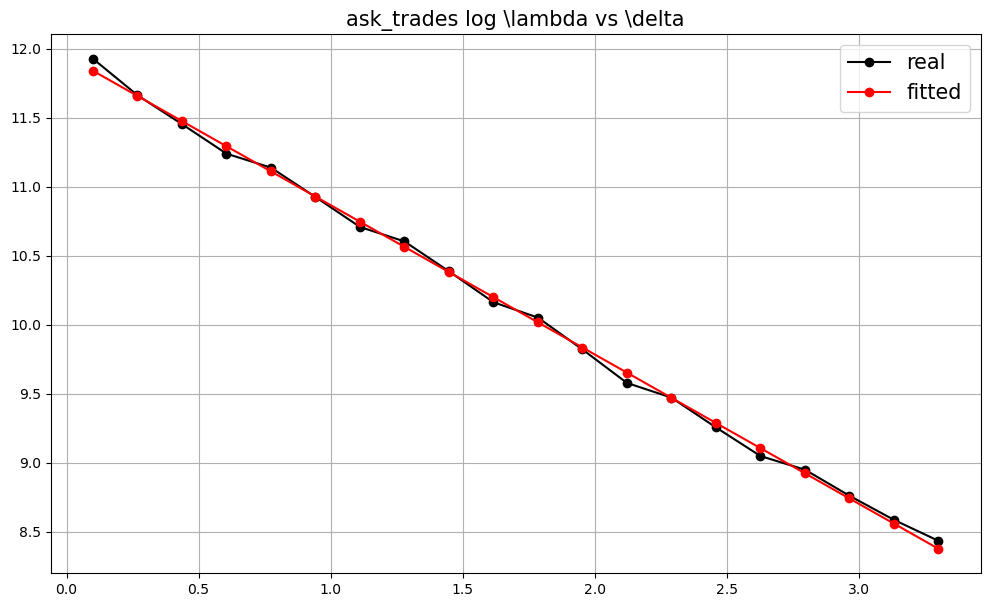

scale:  -1.081779931533557


In [6]:
delta = ask_trades_group.delta.values
dmin = np.min(delta[delta > 0])
dmax = np.quantile(delta[delta > 0], 0.97)

deltas = np.linspace(dmin, dmax, 20)

res = np.zeros_like(deltas)

for i, d in enumerate(deltas):
    res[i] = np.sum( delta >= d )

scale, loc = np.polyfit(deltas, np.log(res), deg=1)
    
y = loc + deltas * scale

plt.figure(figsize=(12, 7))
plt.title("ask_trades log \lambda vs \delta", fontsize=15)
plt.plot(deltas, np.log(res), '-ok', label='real')
plt.plot(deltas, y, '-or', label='fitted')
plt.grid()
plt.legend(fontsize=15)
plt.show()

print("scale: ", scale)

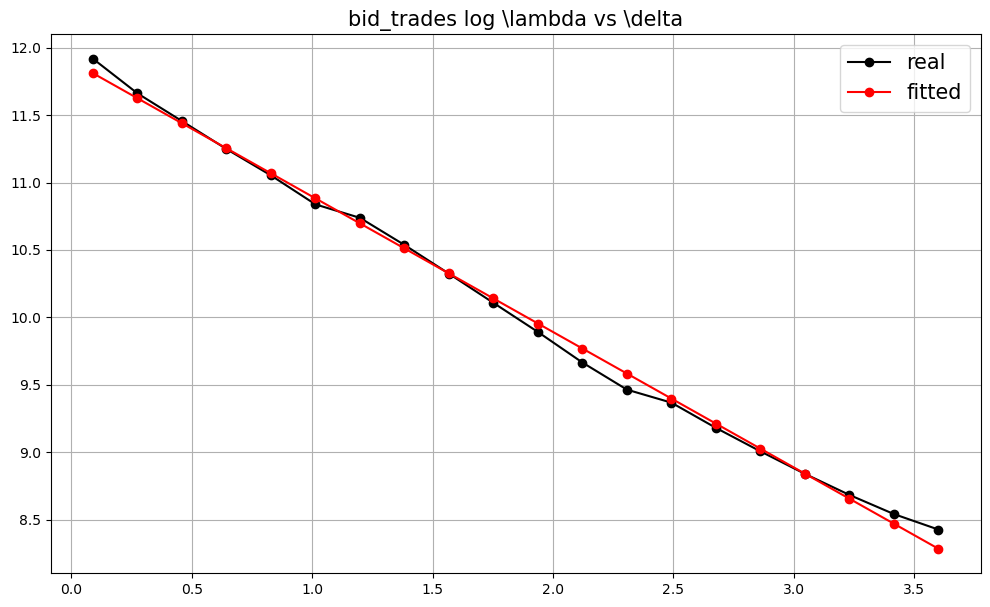

scale:  -1.0045402336999556


In [7]:
delta = bid_trades_group.delta.values
dmin = np.min(delta[delta > 0])
dmax = np.quantile(delta[delta > 0], 0.97)

deltas = np.linspace(dmin, dmax, 20)

res = np.zeros_like(deltas)

for i, d in enumerate(deltas):
    res[i] = np.sum( delta >= d )

scale, loc = np.polyfit(deltas, np.log(res), deg=1)
    
y = loc + deltas * scale

plt.figure(figsize=(12, 7))
plt.title("bid_trades log \lambda vs \delta", fontsize=15)
plt.plot(deltas, np.log(res), '-ok', label='real')
plt.plot(deltas, y, '-or', label='fitted')
plt.grid()
plt.legend(fontsize=15)
plt.show()

print("scale: ", scale)

Видно, что логарифм хорошо приближается линейной функцией. В качестве константы положим $k = 1 \$^{-1}$.

In [1]:
from simulator import Sim
from stoikov_strategy import StoikovStrategy, FutureStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(1, 'h').delta

In [2]:
md = load_md_from_file(path=PATH_TO_FILE, T=T)

In [3]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

#delay between orders
delay = pd.Timedelta(0.5, 's').delta

min_pos = 0.001

In [24]:
strat = StoikovStrategy(delay, min_pos, pd.Timedelta(1, 's').delta, gamma)
res = strat.run(sim = Sim(md, latency, md_latency))    

In [26]:
spread = res['best_ask'] - res['best_bid']

In [28]:
all(spread > 0)

True

In [4]:
gamma_list = [0.001, 0.01, 0.1, 1.0]

results = dict()
for gamma in gamma_list:
    strat = StoikovStrategy(delay, min_pos, pd.Timedelta(1, 's').delta, gamma)
    res = strat.run(sim = Sim(md, latency, md_latency))    
    results[gamma] = res

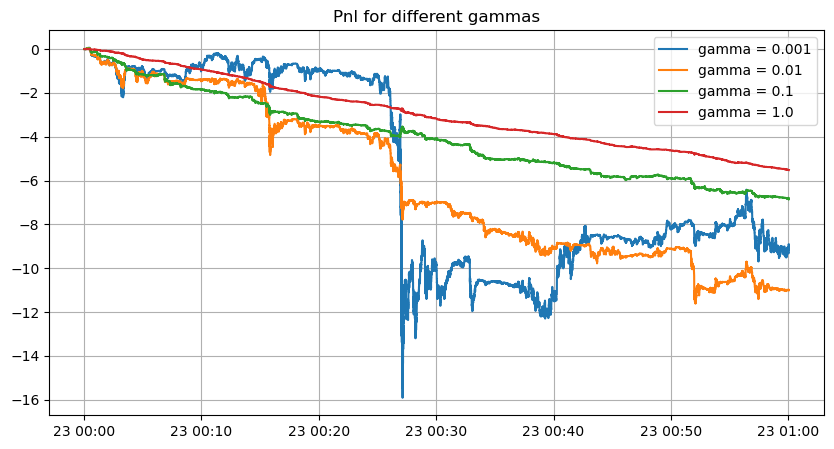

In [5]:
plt.figure(figsize=(10, 5))
plt.title("Pnl for different gammas")
for gamma, res in results.items():
    df = get_pnl(res['update'])
    dt = pd.to_datetime(df.receive_ts)
    plt.step(dt, df.total, '-', label=f'gamma = {gamma}')
plt.grid()
plt.legend()
plt.show()

gamma = 0.001, 	 volume = 6.8840
gamma = 0.01, 	 volume = 6.8900
gamma = 0.1, 	 volume = 6.8480
gamma = 1.0, 	 volume = 6.1810


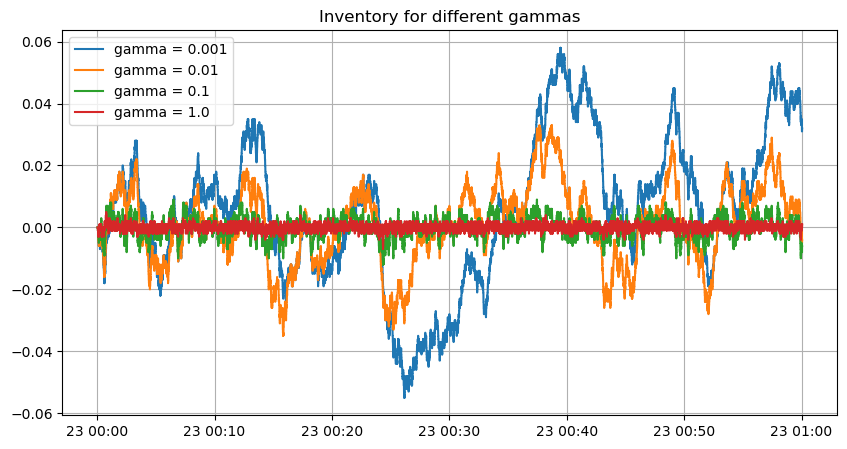

In [6]:
plt.figure(figsize=(10, 5))
plt.title("Inventory for different gammas")
for gamma, res in results.items():
    df = get_pnl(res['update'])
    dt = pd.to_datetime(df.receive_ts)
    plt.step(dt, df.BTC, '-', label=f'gamma = {gamma}')
    
    
    vol = np.sum( np.abs(np.diff( df.BTC )) )
    print(f"gamma = {gamma}, \t volume = {vol:0.4f}")
plt.grid()
plt.legend()
plt.show()

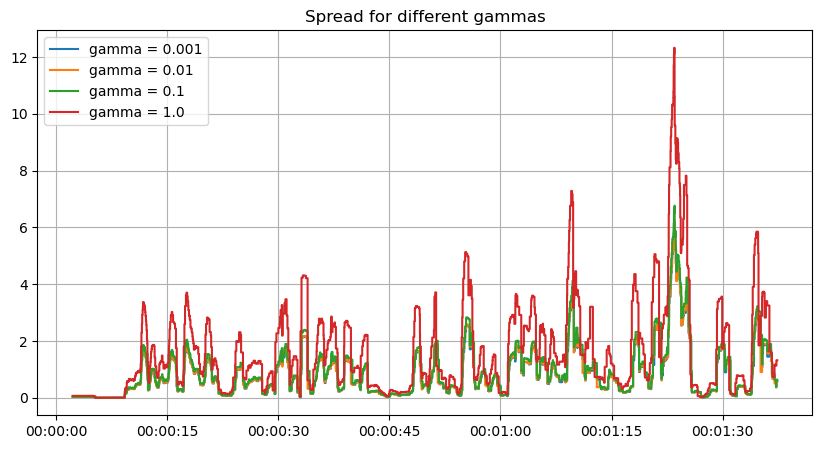

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Spread for different gammas")
i = slice(0, 10000, 10)
for gamma, res in results.items():
    res['spread'] = res['ask_price'] - res['bid_price']
    plt.step(dt.values[i], res['spread'][i],label=f'gamma = {gamma}')
plt.grid()
plt.legend()
plt.show()

Видно, что чем больше `gamma`, тем быстрее мы стремимся закрыть позицию, поэтому `inventory` для больших `gamma`(0.1, 1.0) болтается вокруг нуля. Также видно, что дисперсия `PnL` для больших `gamma` меньше, так как почти всё время у нас либо нулевая позиция, либо очень маленькая.

Нетрудно видеть, что если $\gamma \to 0$, то спред стремится к константе $2/k$. Так как $k = 1$, то спред стремится к двойке. Видно, что у стратегий с малой $\gamma$ спред близок к двойке. У стратегии с $\gamma=1.0$ спред меняется, причем он может быть как больше 2, так и меньше. 

In [8]:
gamma = 0.5

In [9]:
T = pd.Timedelta(1, 's').delta

In [10]:
stoikov = StoikovStrategy(delay, min_pos, T, gamma)
stoikov_spread = StoikovStrategy(delay, min_pos, T, gamma, theta_policy='spread')
midprice = StoikovStrategy(delay, min_pos, T, gamma, res_policy='mid_price')
futprice = FutureStrategy(delay, min_pos, T, gamma, md,theta_policy='spread', inventory_policy='neutral', q0=10)

strats = {
    'stoikov' : stoikov,
    'stoikov_spread': stoikov_spread,
    'mid_price': midprice, 
    'future_price': futprice,
}

In [11]:
res = {}
dfs = {}

for name, strat in strats.items():
    res[name] = strat.run(sim = Sim(md, latency, md_latency))
    dfs[name] = get_pnl( res[name]['update'] )

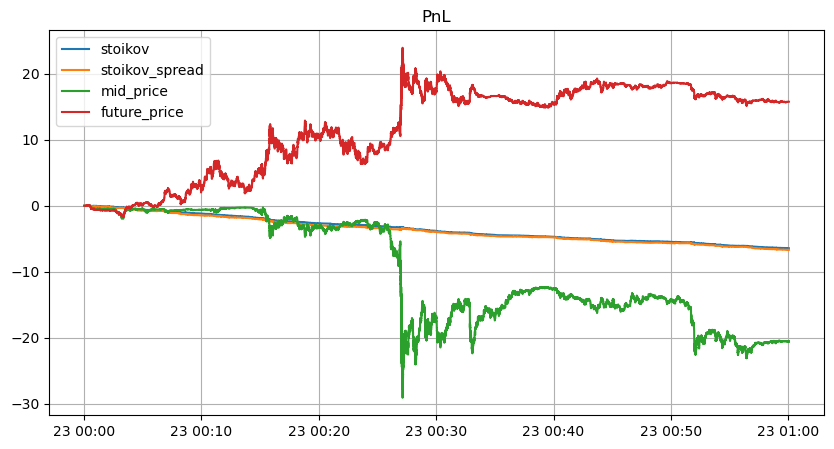

In [12]:
plt.figure(figsize=(10, 5))
plt.title("PnL")
for name, df in dfs.items():

    dt = pd.to_datetime(df.receive_ts)

    plt.step(dt, df.total, '-', label=name)
plt.legend()
plt.grid()
plt.show()

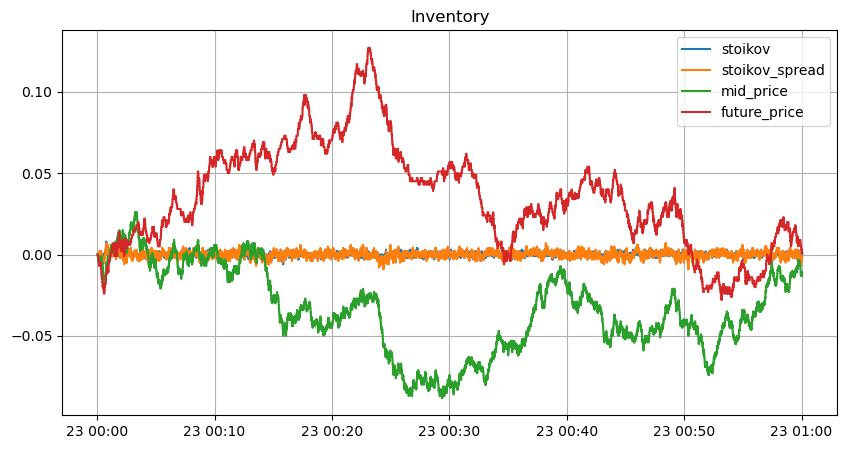

In [13]:
plt.figure(figsize=(10, 5))

plt.title("Inventory")
for name, df in dfs.items():

    dt = pd.to_datetime(df.receive_ts)

    plt.step(dt, df.BTC, '-', label=name)
plt.legend()
plt.grid()
plt.show()

In [14]:
def calc_vol(df):
    return np.sum( np.abs( np.diff(df.BTC) ) )

In [15]:
for name, df in dfs.items():
    vol = calc_vol(df)
    print(f'{name},\t\t vol={vol}')

stoikov,		 vol=6.632999999999998
stoikov_spread,		 vol=7.9270000000000005
mid_price,		 vol=6.123000000000001
future_price,		 vol=3.4690000000000007


На графиках видно, что стратегии `mid_price` и `future_price` почти не отличается, у второй `PnL` чуть больше. Стратегия Стоикова сильно от них отличается, у неё меньше дисперсия и меньше разброс `inventory`. Суммарный объем оказывается больше. 